# Sequence Analysis: Arsenal, 2003-04

This workflow uses data sourced from [Statsbomb open data](https://statsbomb.com/what-we-do/hub/free-data/). It aims to identify common events and sequences of events which immediately precede shots (incl goals) and visualise these for the purpose of informing tactics.

[API usage instructions](https://github.com/statsbomb/statsbombpy/tree/master/statsbombpy)<br>

[PrexfixSpan-py](https://github.com/chuanconggao/PrefixSpan-py)<br>

Up the Gunners

Import libraries

Retrieve data

Clean and prepare data

Explore data

    * events
    
    * leading events
    
Analysis

In [73]:
# import libraries
from statsbombpy import sb
from mplsoccer.pitch import Pitch
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from prefixspan import PrefixSpan
import pandas as pd
from scipy.stats import rankdata
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [6]:
# read event data for all 03/04 premier league games (only Arsenal available free)

import warnings
warnings.filterwarnings('ignore')

all_events = sb.competition_events(
    country="England",
    division= "Premier League",
    season="2003/2004",
    gender="male"
)

/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/harrychurchley/opt/anaconda3/lib/python3.9/site-packages/statsbombpy/api_client.py:21: NoAuthWarni

In [11]:
all_events.shape

(129401, 111)

## Data Preparation and Cleaning

In [55]:
# identify columns of interest

#list(all_events)

req_cols=['match_id','index','type','team','player','player_id',
          'position','shot_statsbomb_xg', 'shot_outcome','location', 
          'pass_end_location','carry_end_location', 'pass_recipient']

events=all_events[req_cols]

In [56]:
#match_1_ars=match_1_events[match_1_events['team']=='Arsenal'].reset_index(drop=True)

In [57]:
events=events[events['team']=='Arsenal']

In [58]:
# clean player_id
events['player_id'] = events['player_id'].fillna('00000') # replace NAs
events['player_id'] = events['player_id'].astype(str).str.split('.', expand=True)[0] # .0

# split location coordinates to X and Y cols
events[['location_x', 'location_y']] = events['location'].str.extract(r'\[(.*), (.*)\]').astype(float) 
events[['pass.end_location_x', 'pass.end_location_y']] = events['pass_end_location'].str.extract(r'\[(.*), (.*)\]').astype(float)
events[['carry.end_location_x', 'carry.end_location_y']] = events['carry_end_location'].str.extract(r'\[(.*), (.*)\]').astype(float)

# drop orginal cols
events = events.drop(['location', 'pass_end_location', 'carry_end_location'], axis=1)

# add type_id column
label_encoder = LabelEncoder() # Create an instance of LabelEncoder
encoded_column = label_encoder.fit_transform(events['type']) # Fit the encoder on the categorical column
encoded_column_int = ['{:02d}'.format(val) for val in encoded_column] # Add leading 0s
events['type_id'] = encoded_column_int # Create a new column with the encoded values

# add column combining type and player
events["type_player"] = events["type_id"].astype(str) + events["player_id"].astype(str)

# correctly sort events
#events=events

#remove unwanted events
#match_1_events = match_1_events[match_1_events['type'] != 'Carry']
#match_1_events = match_1_events[match_1_events['type'] != 'Ball Receipt*']

In [59]:
events=events.sort_values(by=['match_id', 'index']).reset_index(drop=True)

In [71]:
# select shots
all_shots=events[events['type']=='Shot']
all_shots['shot_outcome'].value_counts()

shot_outcome
Off T               189
Saved               147
Blocked             101
Goal                 69
Wayward              17
Post                 14
Saved Off Target      5
Saved to Post         2
Name: count, dtype: int64

In [62]:
# for each 'shot' type.name, create a list of the preceding n events. Append each list to a master list.
# also create a list of event indexes.

shot_events = []
event_indexes = []
play_outcome = []
play_xG = []
for i, row in events.iterrows():
    if row['type'] == 'Shot':
        outcome = row['shot_outcome']
        xG = row['shot_statsbomb_xg']
        start_index = max(0, i - 10)  # Calculate the start index, ensuring it doesn't go below 0
        indexes = list(range(start_index, i))
        event_indexes.extend(indexes)
        single_shot_events=[]
        for j in indexes:
            event=events['type_player'][j]
            single_shot_events.append(event)
            play_outcome.append(outcome)
            play_xG.append(xG)
        shot_events.append(single_shot_events)

In [63]:
len(shot_events)

544

In [66]:
# get full leading event data with event indexes and attach shot outcomes

leading_events=events.loc[event_indexes]
leading_events['play_outcome'] = play_outcome 
leading_events['play_xG'] = play_xG
leading_events['play_xG_ranked'] = rankdata(play_xG) / (len(play_xG) + 1)

# create type and player keys
type_key = leading_events[['type', 'type_id']].drop_duplicates().reset_index(drop=True)
player_key = leading_events[['player', 'player_id']].drop_duplicates().reset_index(drop=True)

In [68]:
leading_events.head(5)

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,location_x,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_id,type_player
201,3749052,350,Ball Recovery,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03,0315515
202,3749052,351,Carry,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,0515515
203,3749052,352,Pass,Arsenal,Patrick Vieira,15515,Right Defensive Midfield,NaN,NaN,Eduardo César Daude Gaspar,NaN,NaN,NaN,NaN,NaN,NaN,23,2315515
204,3749052,353,Ball Receipt*,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02,0226014
205,3749052,354,Carry,Arsenal,Eduardo César Daude Gaspar,26014,Left Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05,0526014


## Data Exploration

We are interested in the events that occur in the lead up to shots. However, shots themselves can vary in terms of the danger they pose to the opposition. We can investigate this using the shot_outcome and shot_statsbomb_xg variables.

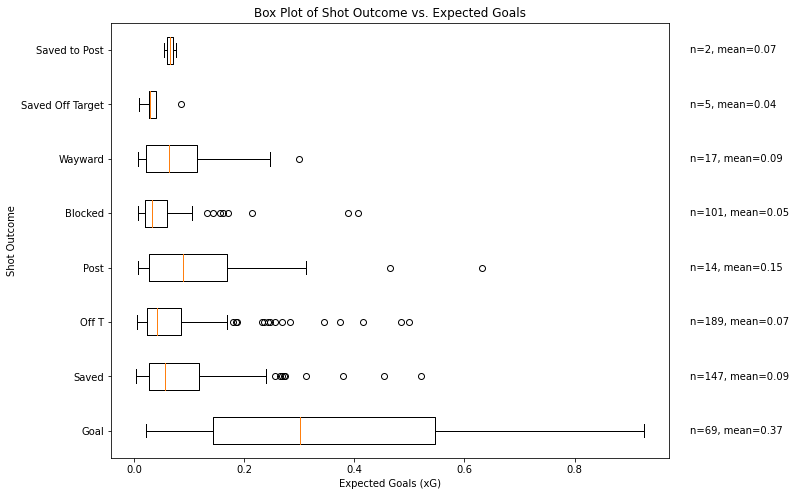

In [74]:
# box plot - xG by shot outcome 
shot_outcome = all_shots['shot_outcome']
shot_statsbomb_xg = all_shots['shot_statsbomb_xg']

# Group the shot_statsbomb_xg data based on shot_outcome
data = [shot_statsbomb_xg[shot_outcome == outcome] for outcome in shot_outcome.unique()]

# Create a horizontal box plot with a larger figure size
plt.figure(figsize=(10, 8))
box_plot = plt.boxplot(data, labels=shot_outcome.unique(), vert=False)

# Set labels and title
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Shot Outcome')
plt.title('Box Plot of Shot Outcome vs. Expected Goals')

# Add counts and mean xG to the plot
for i, outcome in enumerate(shot_outcome.unique()):
    count = len(data[i])
    mean_xg = np.mean(data[i])
    plt.text(1.01, i + 1, f'n={count}, mean={mean_xg:.2f}', va='center', ha='left')

# Display the plot
plt.show()

In [81]:
leading_group=leading_events['type'].value_counts()

In [82]:
all_events_group=events['type'].value_counts()

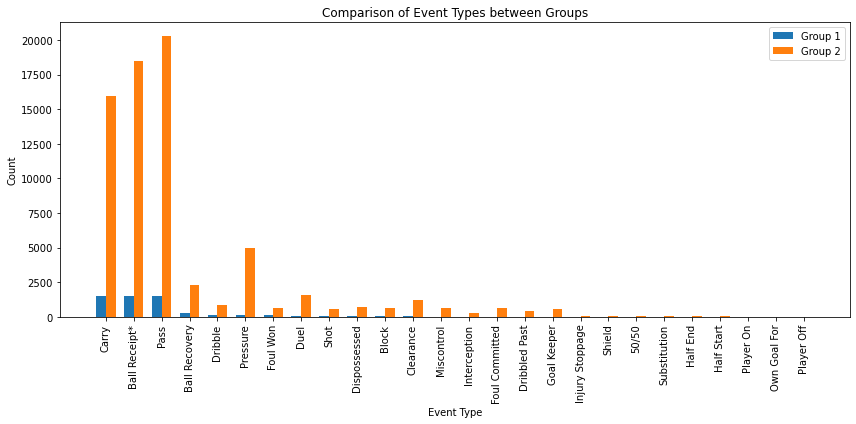

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Extract the categories and their counts from both groups
categories = leading_group.index
group1_counts = leading_group.values
group2_counts = all_events_group[categories].values

# Calculate the x-axis positions for the bars
x = np.arange(len(categories))

# Width of the bars
bar_width = 0.35

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars for Group 1
rects1 = ax.bar(x - bar_width/2, group1_counts, bar_width, label='Group 1')

# Plot the bars for Group 2
rects2 = ax.bar(x + bar_width/2, group2_counts, bar_width, label='Group 2')

# Set the x-axis labels and title
ax.set_xlabel('Event Type')
ax.set_ylabel('Count')
ax.set_title('Comparison of Event Types between Groups')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=90)

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [468]:
# use ps algorithm on shot events list of lists.
ps = PrefixSpan(shot_events)

results = ps.frequent(100)

In [469]:
# sort results by support count (desc)
sorted_results = sorted(results, key=lambda x: x[0], reverse=True)
sorted_results

[(366, ['0215516']),
 (321, ['0515516']),
 (293, ['0215516', '0515516']),
 (279, ['2319312']),
 (271, ['0219312']),
 (253, ['2315516']),
 (250, ['0519312']),
 (225, ['0219312', '0519312']),
 (224, ['2315515']),
 (221, ['0219312', '2319312']),
 (216, ['0519312', '2319312']),
 (207, ['0515515']),
 (205, ['0215516', '2315516']),
 (202, ['2340222']),
 (202, ['0215515']),
 (198, ['0515516', '2315516']),
 (194, ['0219312', '0519312', '2319312']),
 (190, ['0215754']),
 (184, ['0515515', '2315515']),
 (183, ['2312529']),
 (179, ['2340221']),
 (175, ['0215516', '0515516', '2315516']),
 (171, ['0240221']),
 (170, ['0215515', '0515515']),
 (166, ['0215515', '2315515']),
 (165, ['0240222']),
 (165, ['0540222']),
 (163, ['0215042']),
 (159, ['0540222', '2340222']),
 (157, ['0515754']),
 (156, ['0240222', '2340222']),
 (155, ['0212529']),
 (154, ['2319312', '0215516']),
 (154, ['0540221']),
 (152, ['0240222', '0540222']),
 (149, ['0215515', '0515515', '2315515']),
 (146, ['0240222', '0540222', '2340

In [470]:
# select most common event
common_event=str(sorted_results[0][1][0])
common_event

'0215516'

In [471]:
# find data on all occurences of most common event
common_event_data=leading_events[leading_events['type_player']==common_event].reset_index(drop=True)
common_event_data.head()

,match_id,index,type,team,player,player_id,position,shot_statsbomb_xg,shot_outcome,pass_recipient,...,location_y,pass.end_location_x,pass.end_location_y,carry.end_location_x,carry.end_location_y,type_id,type_player,play_outcome,play_xG,play_xG_ranked
0,3749052,343,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,75.6,NaN,NaN,NaN,NaN,02,0215516,Goal,0.193885,0.844637
1,3749052,347,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,60.7,NaN,NaN,NaN,NaN,02,0215516,Goal,0.193885,0.844637
2,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,9.4,NaN,NaN,NaN,NaN,02,0215516,Saved,0.007914,0.045079
3,3749052,472,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,9.4,NaN,NaN,NaN,NaN,02,0215516,Off T,0.125604,0.758248
4,3749052,1463,Ball Receipt*,Arsenal,Thierry Henry,15516,Left Center Forward,NaN,NaN,NaN,...,41.0,NaN,NaN,NaN,NaN,02,0215516,Saved,0.147070,0.798686


In [472]:
n_shots=len(match_1_shots)
n_common_events=len(common_event_data)
player_name=common_event_data.loc[0]['player']
type_name=common_event_data.loc[0]['type']
pc_common_event=round((n_common_events/n_shots)*100,2)

print(f"In the 2003-04 season, Arsenal had {n_shots} shots. {pc_common_event}% of these were preceeded by a {type_name} by {player_name}.")

In the 2003-04 season, Arsenal had 544 shots. 89.52% of these were preceeded by a Ball Receipt* by Thierry Henry.


In [473]:
import numpy as np
common_event_data['col']=np.where(common_event_data['play_outcome']=="Goal", "red", "black")


In [474]:
common_event[:2]

'02'

In [475]:
# box plots of xG and shot outcome

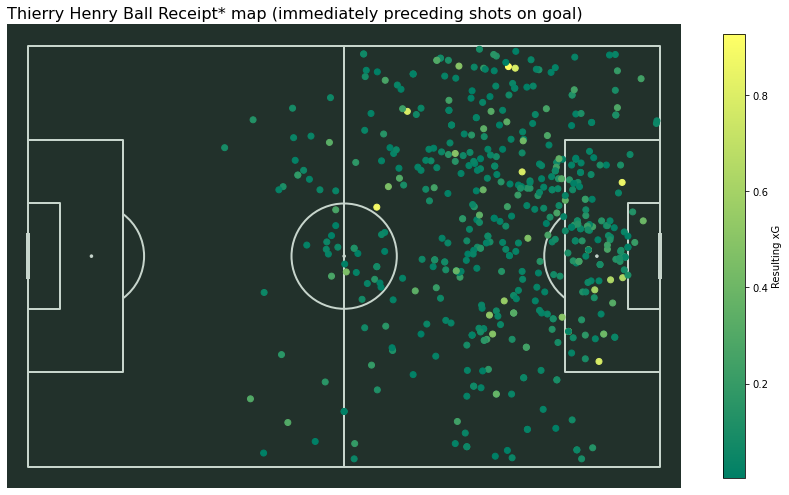

In [476]:
# visualise events
cmap_scheme='summer'
cmap = plt.cm.get_cmap(cmap_scheme)
color_by='play_xG'
colors = cmap(common_event_data[color_by])

event_id= common_event[:-5]
#pitch = Pitch(pitch_color='grass', line_color='white', stripe=False)
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(12, 8))

if event_id=='02':
    ax.scatter(common_event_data['location_x'], common_event_data['location_y'], c=common_event_data[color_by],
               cmap=cmap_scheme, zorder=10)
elif event_id=='23':
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['pass.end_location_x'] - common_event_data['location_x'], common_event_data['pass.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
elif event_id=='05': 
    ax.quiver(common_event_data['location_x'], common_event_data['location_y'], 
             common_event_data['carry.end_location_x'] - common_event_data['location_x'], common_event_data['carry.end_location_y'] - common_event_data['location_y'], 
             color=colors, scale_units='xy', angles='xy', scale=1, width=0.002)
else:
    print("Event must be a ball receipt, carry or pass")
ax.set_title(f"{player_name} {type_name} map (immediately preceding shots on goal)", fontsize=16, loc='left')
ax.title.set_position([0.5, 1.05])

# Add colorbar legend
sm = ScalarMappable(cmap=cmap)
sm.set_array(common_event_data[color_by])
plt.colorbar(sm, ax=ax, shrink=0.8, label="Resulting xG")
plt.show()
#plt.savefig("th14.png")

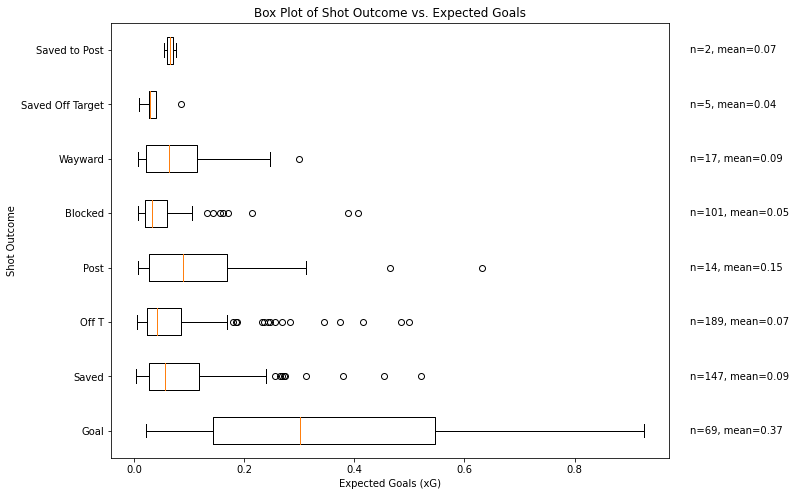

In [477]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'match_1_shots'
shot_outcome = match_1_shots['shot_outcome']
shot_statsbomb_xg = match_1_shots['shot_statsbomb_xg']

# Group the shot_statsbomb_xg data based on shot_outcome
data = [shot_statsbomb_xg[shot_outcome == outcome] for outcome in shot_outcome.unique()]

# Create a horizontal box plot with a larger figure size
plt.figure(figsize=(10, 8))
box_plot = plt.boxplot(data, labels=shot_outcome.unique(), vert=False)

# Set labels and title
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Shot Outcome')
plt.title('Box Plot of Shot Outcome vs. Expected Goals')

# Add counts and mean xG to the plot
for i, outcome in enumerate(shot_outcome.unique()):
    count = len(data[i])
    mean_xg = np.mean(data[i])
    plt.text(1.01, i + 1, f'n={count}, mean={mean_xg:.2f}', va='center', ha='left')

# Display the plot
plt.show()


In [478]:
# caveats

# good opportunities != shots and xG. Martinelli vs Liverpool
# For example, a counter attacking 3v1 situation may appear a good goal scoring opportunity. However, 
# should the attacker in possession fail to execute their pass to a teammate, a shot (and cosequently, xG) 
# may not be recorded

In [479]:
from collections import Counter

# Flatten the sequences into individual items
items = [item for sublist in shot_events for item in sublist]

# Calculate the frequency of each subsequence
subsequence_length = 4  # Set the length of subsequences you want to find
frequencies = Counter(tuple(items[i:i+subsequence_length]) for i in range(len(items)-subsequence_length+1))

# Find the most common subsequences and their frequencies
most_common = frequencies.most_common()

# Print the top 10 most common subsequences
for subsequence, count in most_common[:20]:
    print(f"Subsequence: {subsequence}, Frequency: {count}")


Subsequence: ('0519312', '2319312', '0215516', '0515516'), Frequency: 58
Subsequence: ('0219312', '0519312', '2319312', '0215516'), Frequency: 49
Subsequence: ('0215516', '0515516', '0815516', '0515516'), Frequency: 41
Subsequence: ('0515515', '2315515', '0219312', '0519312'), Frequency: 35
Subsequence: ('0219312', '0519312', '2319312', '0212529'), Frequency: 34
Subsequence: ('0515515', '2315515', '0215516', '0515516'), Frequency: 34
Subsequence: ('0215515', '0515515', '2315515', '0219312'), Frequency: 33
Subsequence: ('2315515', '0219312', '0519312', '2319312'), Frequency: 33
Subsequence: ('0215515', '0515515', '2315515', '0215516'), Frequency: 33
Subsequence: ('2340221', '0240222', '0540222', '2340222'), Frequency: 32
Subsequence: ('2319312', '0212529', '0512529', '2312529'), Frequency: 32
Subsequence: ('0512529', '2312529', '0219312', '0519312'), Frequency: 31
Subsequence: ('2312529', '0219312', '0519312', '2319312'), Frequency: 31
Subsequence: ('0515754', '2315754', '0215516', '051

In [432]:
player_key

,player,player_id
0,Laureano Bisan-Etame Mayer,40222
1,Thierry Henry,15516
2,Dennis Bergkamp,15042
3,Patrick Vieira,15515
4,Eduardo César Daude Gaspar,26014
5,Ashley Cole,12529
6,Robert Pirès,19312
7,Gilberto Aparecido da Silva,40221
8,Kolo Habib Touré,38412
9,Jens Lehmann,20015


In [434]:
type_key

,type,type_id
0,Pass,23
1,Duel,10
2,Ball Recovery,03
3,Carry,05
4,Shot,29
5,Dribble,08
6,Pressure,26
7,Foul Committed,12
8,Goal Keeper,14
9,Dispossessed,07
